In [1]:
# ============================================================
# VAR Forecasting for 20" Soil Temp (°F)
# Using only Granger-significant predictors
# ============================================================

import pandas as pd
from statsmodels.tsa.api import VAR

# ------------------------------------------
# Load the stationary dataset
# (produced earlier in your workflow)
# ------------------------------------------
df = pd.read_csv("WholeYear_Cleaned.csv")
df["Time (LST)"] = pd.to_datetime(df["Time (LST)"])
df = df.set_index("Time (LST)")

# ------------------------------------------
# Variables that were IMPORTANT for forecasting 20" Soil Temp
# ------------------------------------------
important_vars_20T = [
    'Air Temp (°F)',
    '0.5 m Air Temp (°F)',
    '1.5 m Air Temp (°F)',
    '3 m Air Temp (°F)',
    'Relative Humidity (%)',
    'Solar Radiation (W / m²)',
    'Wind Speed (mph)',
    'Wind Direction (°)',
    'Wind Gust (mph)',
    '4" Bare Soil Temp (°F)',
    '4" Grass Soil Temp (°F)',
    '2" Soil Temp (°F)',
    '4" Soil Temp (°F)',
    '8" Soil Temp (°F)',
    '4" Soil Water Content (%)',
    'Inversion Strength',
    'Max Inversion'
]

Y2_var = '20" Soil Temp (°F)'

# ------------------------------------------
# Build VAR dataframe
# ------------------------------------------
df_var = df[[Y2_var] + important_vars_20T].dropna()

# ------------------------------------------
# Fit the VAR model
# ------------------------------------------
model = VAR(df_var)
lag_selection = model.select_order(15)
optimal_lag = lag_selection.aic
print("Optimal VAR lag =", optimal_lag)

var_model = model.fit(optimal_lag)
print(var_model.summary())

# ------------------------------------------
# Forecast ahead (example: next 48 hours)
# ------------------------------------------
forecast_steps = 24
forecast_values = var_model.forecast(df_var.values[-optimal_lag:], steps=forecast_steps)

# Put forecast into dataframe
forecast_df = pd.DataFrame(
    forecast_values,
    columns=df_var.columns
)

print("\nForecast (first 10 rows):")
print(forecast_df.head(10))

# ------------------------------------------
# Save forecast
# ------------------------------------------
forecast_df.to_csv("Forecast_20in_SoilTemp_VAR.csv")
print("\nSaved: Forecast_20in_SoilTemp_VAR.csv")


/Users/saurabh/Documents/codes/Nvidia/.conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/saurabh/Documents/codes/Nvidia/.conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal VAR lag = 9
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 10, Dec, 2025
Time:                     04:22:01
--------------------------------------------------------------------
No. of Equations:         18.0000    BIC:                   -17.5659
Nobs:                     4944.00    HQIC:                  -20.0729
Log likelihood:          -70373.0    FPE:                4.95024e-10
AIC:                     -21.4268    Det(Omega_mle):     2.76091e-10
--------------------------------------------------------------------
Results for equation 20" Soil Temp (°F)
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                                0.020878         0.026174            0.798           0.425
L1.20" Soil Temp (°F)                0.951150         0.014693 

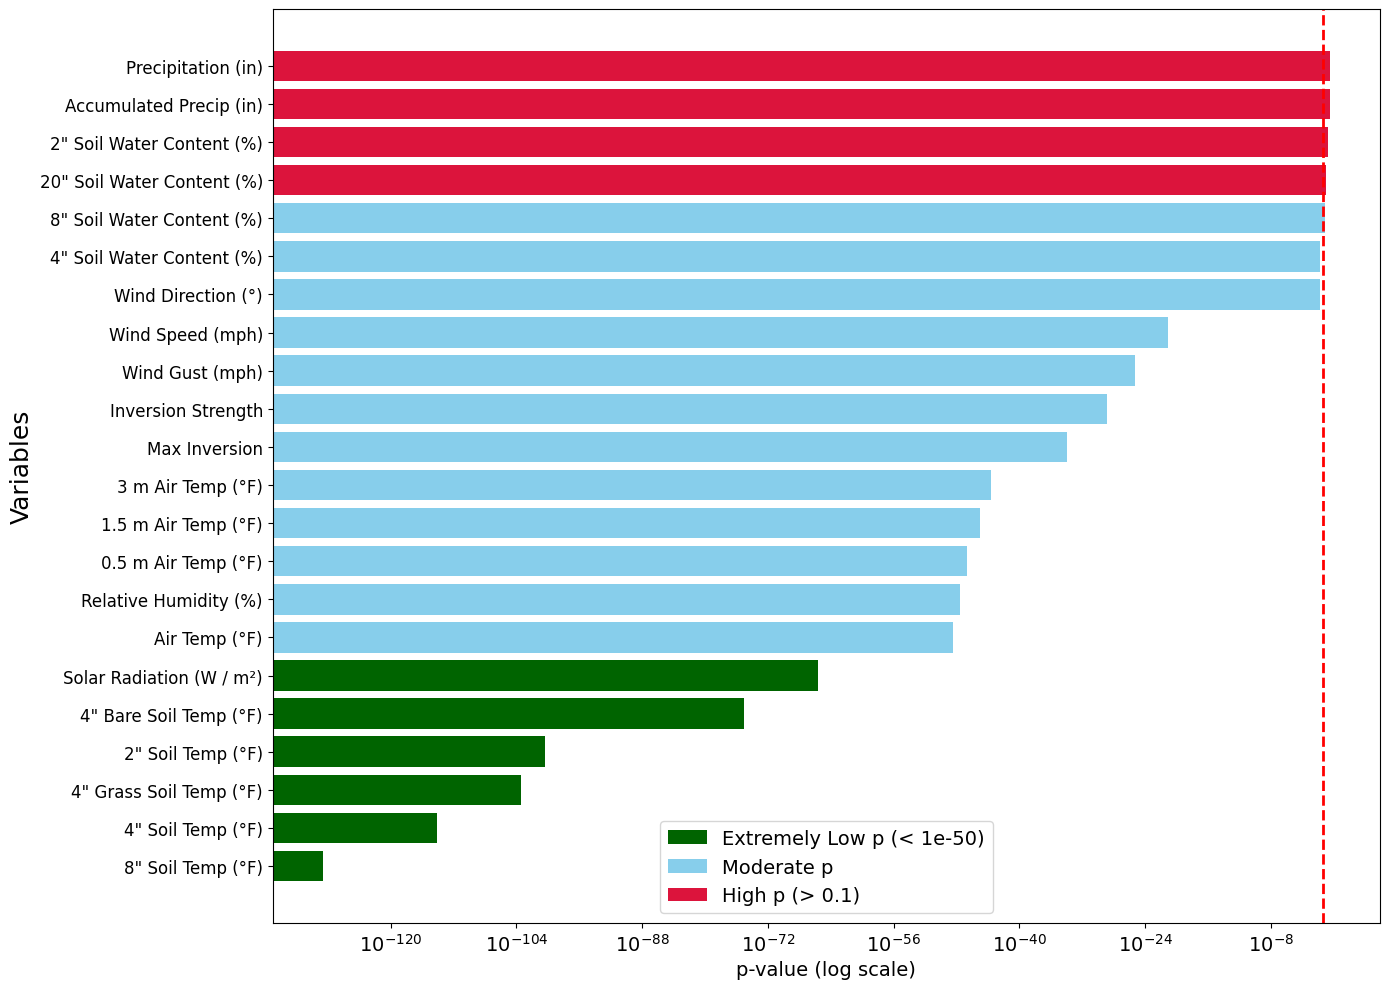

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch

# Provided p-values
p_values_20T = {
    'Air Temp (°F)': 3.591676665687913e-49,
    '0.5 m Air Temp (°F)': 2.108842357432897e-47,
    '1.5 m Air Temp (°F)': 1.0664944573651606e-45,
    '3 m Air Temp (°F)': 2.4745850378344753e-44,
    'Relative Humidity (%)': 3.2089089546129425e-48,
    'Precipitation (in)': 0.315365459800575,
    'Accumulated Precip (in)': 0.315365459800575,
    'Solar Radiation (W / m²)': 2.5328851907563936e-66,
    'Wind Speed (mph)': 8.079391112661328e-22,
    'Wind Direction (°)': 0.019960338890193757,
    'Wind Gust (mph)': 5.660678745546291e-26,
    '4" Bare Soil Temp (°F)': 1.0088684383735445e-75,
    '4" Grass Soil Temp (°F)': 4.382587187849178e-104,
    '2" Soil Temp (°F)': 3.9509574747597055e-101,
    '2" Soil Water Content (%)': 0.17120031525674198,
    '4" Soil Temp (°F)': 7.409815822117329e-115,
    '4" Soil Water Content (%)': 0.0210526768588289,
    '8" Soil Temp (°F)': 2.495661201034229e-129,
    '8" Soil Water Content (%)': 0.07431566605582667,
    '20" Soil Water Content (%)': 0.1232146043249335,
    'Inversion Strength': 1.5157995959235378e-29,
    'Max Inversion': 1.1565006795313364e-34
}

pvals = pd.Series(p_values_20T).sort_values()

# Thresholds
extremely_low = 1e-50
very_high = 0.1

colors = []
for val in pvals.values:
    if val < extremely_low:
        colors.append("darkgreen")  # swapped: extremely small p is now green
    elif val > very_high:
        colors.append("crimson")  # swapped: high p is now red
    else:
        colors.append("skyblue")

plt.figure(figsize=(14, 10))
plt.barh(pvals.index, pvals.values, color=colors)

plt.axvline(0.05, color="red", linestyle="--", linewidth=2)

plt.xscale("log")
plt.xlabel("p-value (log scale)", fontsize=14)
plt.ylabel("Variables", fontsize=18)
# plt.title("Granger Causality Significance for Predicting 20 inch Soil Temp", fontsize=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

legend_items = [
    Patch(facecolor="darkgreen", label="Extremely Low p (< 1e-50)"),
    Patch(facecolor="skyblue", label="Moderate p"),
    Patch(facecolor="crimson", label="High p (> 0.1)")
]

plt.legend(handles=legend_items, fontsize=14)
plt.tight_layout()
plt.show()


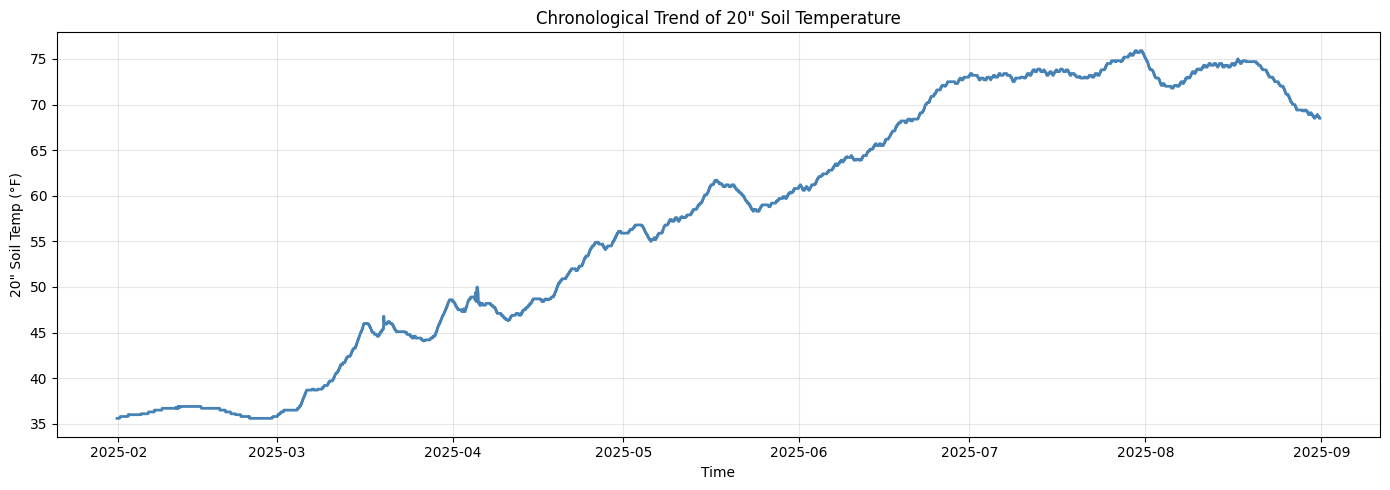

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load raw cleaned dataset (or stationary if you prefer)
df = pd.read_csv("WholeYear_Cleaned.csv")
df["Time (LST)"] = pd.to_datetime(df["Time (LST)"])
df = df.set_index("Time (LST)")

# Plot full chronological trend of 20" Soil Temperature
plt.figure(figsize=(14,5))
plt.plot(df.index, df['20" Soil Temp (°F)'], linewidth=2, color='steelblue')

plt.title('Chronological Trend of 20" Soil Temperature')
plt.xlabel('Time')
plt.ylabel('20" Soil Temp (°F)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Train: 2025-01-31 19:00:00 --> 2025-07-19 23:00:00
Test : 2025-07-20 00:00:00 --> 2025-08-27 11:00:00
Train shape: (4030, 18) Test shape: (923, 18)


/Users/saurabh/Documents/codes/Nvidia/.conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal lag: 5
                     Actual    VAR_24h
Time                                  
2025-07-20 00:00:00    73.0  72.983969
2025-07-20 01:00:00    73.0  72.978510
2025-07-20 02:00:00    73.0  72.962898
2025-07-20 03:00:00    73.0  72.939683
2025-07-20 04:00:00    73.0  72.916992

Rolling 24h VAR Performance:
RMSE: 0.3373849658998797
MAE: 0.2948934907470869


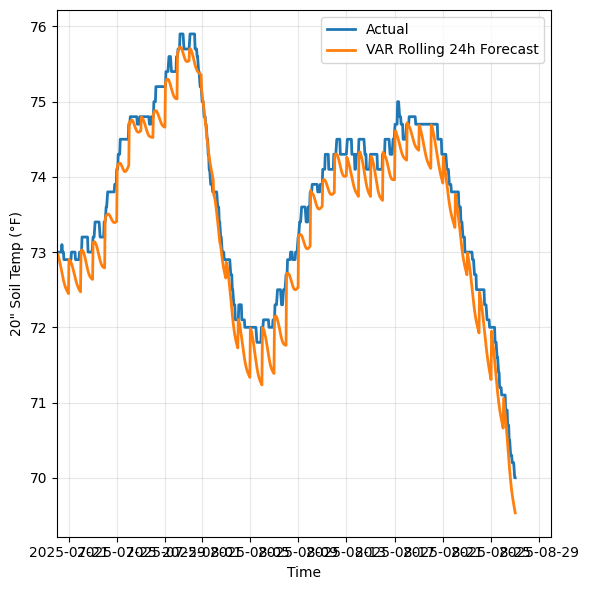

In [22]:

DATE_COL = 'Time (LST)' 
TARGET_COL = '20" Soil Temp (°F)' 
SEQ_LENGTH = 48             # Look back 48 hours
FORECAST_HORIZON = 24       # Predict next 1 day
# ==========================================
# Rolling 24-Hour VAR Forecast Using LSTM Window
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ensure chronological ascending order
df = df.sort_index()

# ---------------------------------------------------------
# 1. Set exact LSTM date range (HARD-CODED FROM OUTPUT)
# ---------------------------------------------------------
LSTM_START = pd.Timestamp("2025-07-20 00:00:00")
LSTM_END   = pd.Timestamp("2025-08-29 23:00:00")

# ---------------------------------------------------------
# 2. Prepare VAR dataframe (Granger-selected vars only)
# ---------------------------------------------------------
df_var = df[[TARGET_COL] + important_vars_20T].dropna()

# Entire training data = everything before LSTM_START
df_train = df_var[df_var.index < LSTM_START].copy()

# Test window = exact LSTM date window
df_test = df_var[(df_var.index >= LSTM_START) & (df_var.index <= LSTM_END)].copy()

print("Train:", df_train.index.min(), "-->", df_train.index.max())
print("Test :", df_test.index.min(),  "-->", df_test.index.max())
print("Train shape:", df_train.shape, "Test shape:", df_test.shape)

# ---------------------------------------------------------
# 3. Fit VAR only on training period
# ---------------------------------------------------------
model = VAR(df_train)
lag_sel = model.select_order(15)
optimal_lag = lag_sel.aic
print("Optimal lag:", optimal_lag)

var_model = model.fit(optimal_lag)

# ---------------------------------------------------------
# 4. Rolling 24-hour forecasting
# ---------------------------------------------------------
FORECAST_HORIZON = 24

rolling_dates = []
rolling_actual = []
rolling_preds = []

test_vals = df_test.values
test_idx = df_test.index

for start in range(0, len(df_test), FORECAST_HORIZON):

    end = start + FORECAST_HORIZON
    if end > len(df_test):
        break

    # True values for this 24h window
    true_chunk = df_test[TARGET_COL].iloc[start:end].values
    rolling_actual.extend(true_chunk)

    date_chunk = test_idx[start:end]
    rolling_dates.extend(date_chunk)

    # Build input history window
    if start == 0:
        history = df_train.values[-optimal_lag:]
    else:
        combined = np.vstack([df_train.values, test_vals[:start]])
        history = combined[-optimal_lag:]

    # Forecast one 24-hour block
    forecast_chunk = var_model.forecast(history, steps=FORECAST_HORIZON)
    rolling_preds.extend(forecast_chunk[:, 0])  # target variable is column zero

# ---------------------------------------------------------
# 5. Build results DataFrame aligned to LSTM stitched timeline
# ---------------------------------------------------------
var_results_df = pd.DataFrame({
    'Time': rolling_dates,
    'Actual': rolling_actual,
    'VAR_24h': rolling_preds
}).set_index('Time')

print(var_results_df.head())

# ---------------------------------------------------------
# 6. Metrics
# ---------------------------------------------------------
rmse = np.sqrt(mean_squared_error(var_results_df['Actual'], var_results_df['VAR_24h']))
mae = mean_absolute_error(var_results_df['Actual'], var_results_df['VAR_24h'])

print("\nRolling 24h VAR Performance:")
print("RMSE:", rmse)
print("MAE:", mae)

# ---------------------------------------------------------
# 7. Plot WITH EXACT LSTM DATE RANGE
# ---------------------------------------------------------
plt.figure(figsize=(6,6))
plt.plot(var_results_df.index, var_results_df['Actual'], label='Actual', linewidth=2)
plt.plot(var_results_df.index, var_results_df['VAR_24h'], label='VAR Rolling 24h Forecast', linewidth=2)

# plt.title('Rolling 24-Hour VAR Forecast (Aligned with LSTM Window)')
plt.xlabel("Time")
plt.ylabel('20\" Soil Temp (°F)')
plt.grid(alpha=0.3)
plt.legend()

# FORCE x-axis to exact LSTM forecast range
plt.xlim(LSTM_START, LSTM_END)

plt.tight_layout()
plt.show()


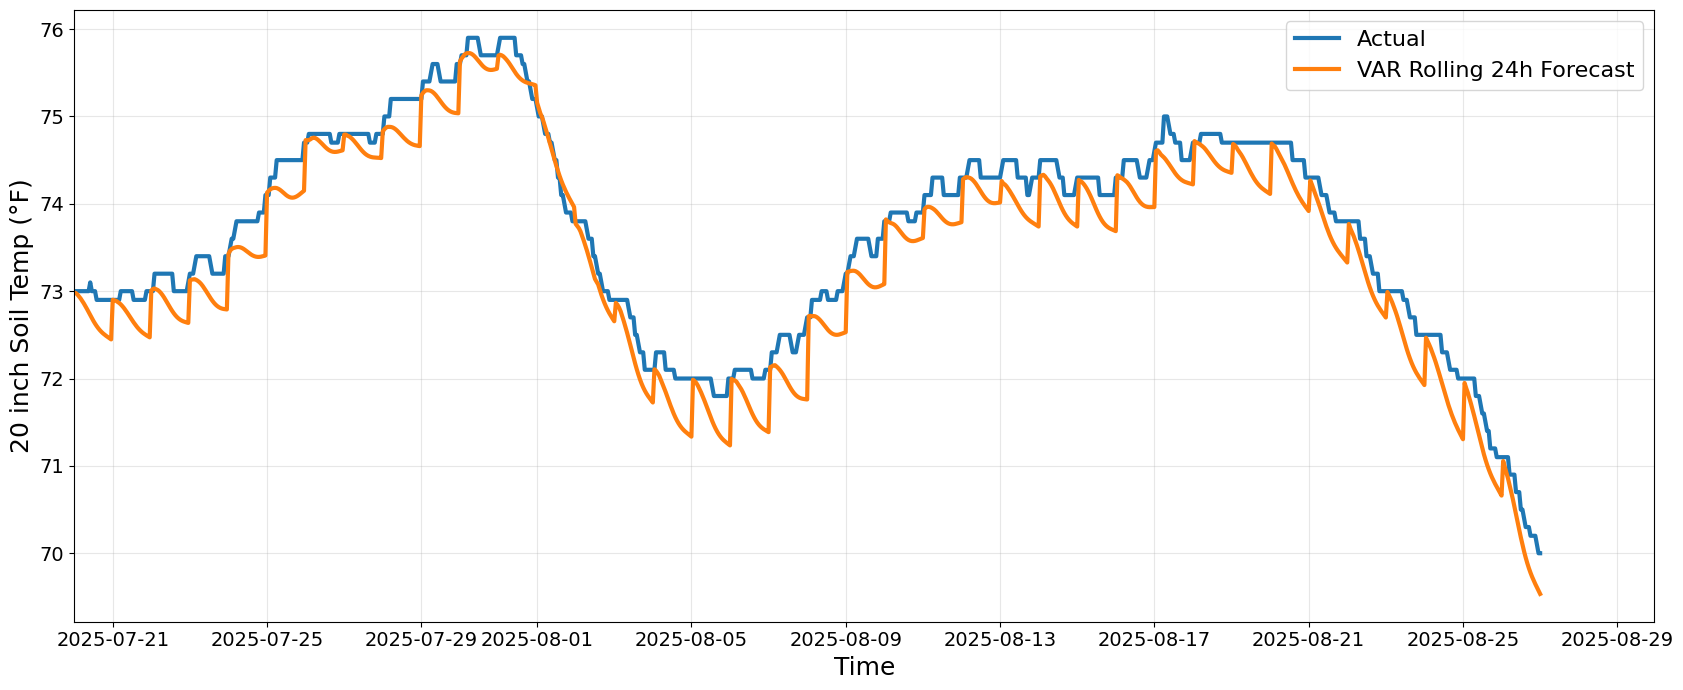

In [14]:
import matplotlib.pyplot as plt

# Assuming var_results_df, LSTM_START, LSTM_END already exist in the environment
plt.figure(figsize=(17, 7))

plt.plot(var_results_df.index, var_results_df['Actual'], label='Actual', linewidth=3)
plt.plot(var_results_df.index, var_results_df['VAR_24h'], label='VAR Rolling 24h Forecast', linewidth=3)

# plt.title('Rolling 24 Hour VAR Forecast vs Actual', fontsize=22)
plt.xlabel("Time", fontsize=18)
plt.ylabel('20 inch Soil Temp (°F)', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(alpha=0.3)
plt.legend(fontsize=16)

plt.xlim(LSTM_START, LSTM_END)

plt.tight_layout()
plt.show()


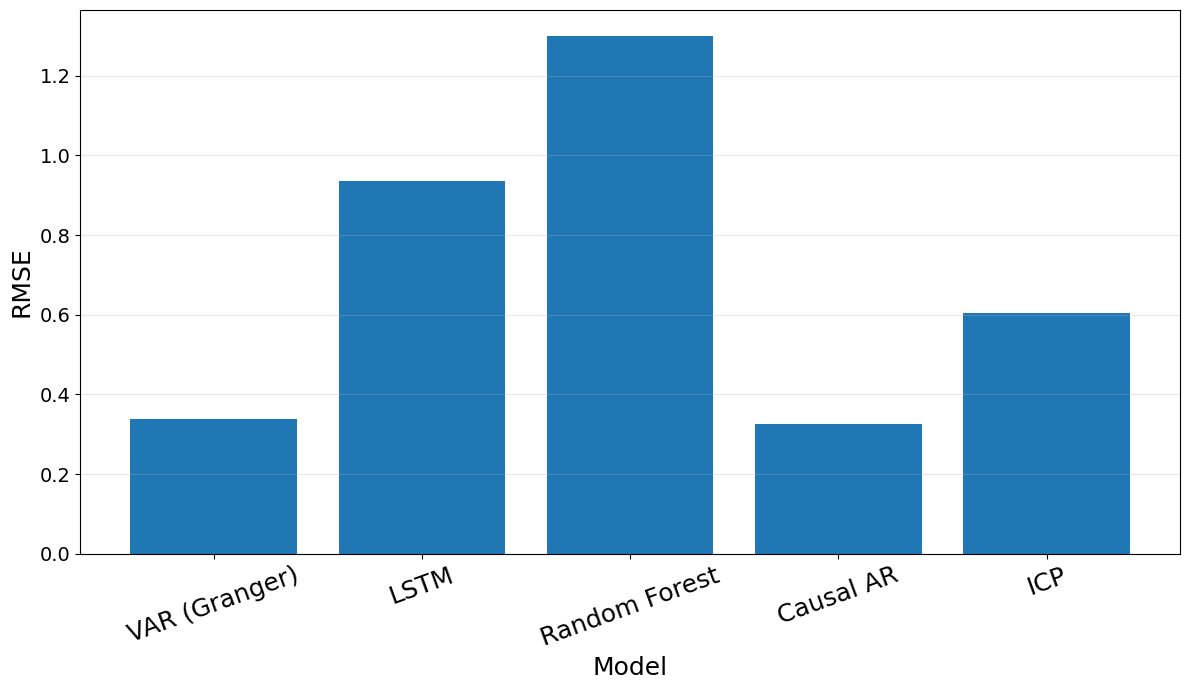

In [17]:
import matplotlib.pyplot as plt

# Updated RMSE values and method names
methods = [
    "VAR (Granger)",
    "LSTM",
    "Random Forest",
    "Causal AR",   # renamed from AR
    "ICP"
]

rmse_values = [
    0.337,     # VAR
    0.9361,    # LSTM
    1.3001,    # RF
    0.3248,    # Causal AR
    0.6041     # ICP
]

plt.figure(figsize=(12, 7))

plt.bar(methods, rmse_values)

plt.ylabel("RMSE", fontsize=18)
plt.xlabel("Model", fontsize=18)

plt.xticks(rotation=20, fontsize=18)   # increased font size
plt.yticks(fontsize=14)

plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()
